<a href="https://colab.research.google.com/github/guyyariv/DL_ex3/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import copy
import os
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import imageio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
## load mnist dataset
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Creating data sets

In [115]:
batch_size = 64
latent_dim = 20
train_size_for_mlp = 0.0033

root = './data'
if not os.path.exists(root):
    os.mkdir(root)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)

trainset_mlp, trainset_autoencoder = torch.utils.data.random_split(trainset, [int(60000 * train_size_for_mlp), int(60000 * (1 - train_size_for_mlp))])

train_loader_mlp = DataLoader(
    trainset_mlp, batch_size=batch_size, shuffle=True
)

train_loader_autoencoder = DataLoader(
    trainset_autoencoder, batch_size=batch_size, shuffle=True
)

trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)


def calculate_accuracy(y_true, y_pred, is_training=False):
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)

    return torch.sum(y_true == y_pred) / len(y_true)

# Autoencoder architecture

In [116]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(256, latent_dim)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x).reshape((x.shape[0], 256))  # compressed representation
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.fc = nn.Linear(latent_dim, 256)
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        ## decode ##
        x = self.fc(x).reshape((x.shape[0], 4, 8, 8))
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))
        return x


class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Train Autoencoder

935it [00:38, 24.22it/s]                         


Epoch:1, Loss:0.2457


935it [00:45, 20.76it/s]


Epoch:2, Loss:0.1451


935it [00:38, 24.58it/s]                         


Epoch:3, Loss:0.1353


935it [00:37, 24.65it/s]                         


Epoch:4, Loss:0.1322


935it [00:37, 24.89it/s]                         


Epoch:5, Loss:0.1305


935it [00:37, 24.82it/s]                         


Epoch:6, Loss:0.1295


935it [00:37, 24.83it/s]                         


Epoch:7, Loss:0.1287


935it [00:37, 25.03it/s]                         


Epoch:8, Loss:0.1281


935it [00:37, 24.90it/s]                         


Epoch:9, Loss:0.1276


935it [00:37, 24.91it/s]                         


Epoch:10, Loss:0.1272


935it [00:37, 24.77it/s]                         


Epoch:11, Loss:0.1268


935it [00:37, 24.69it/s]                         


Epoch:12, Loss:0.1265


935it [00:37, 24.74it/s]                         


Epoch:13, Loss:0.1262


935it [00:38, 24.53it/s]                         


Epoch:14, Loss:0.1259


935it [00:38, 24.58it/s]                         


Epoch:15, Loss:0.1257


935it [00:37, 24.66it/s]                         


Epoch:16, Loss:0.1256


935it [00:37, 24.62it/s]                         


Epoch:17, Loss:0.1254


935it [00:38, 24.56it/s]                         


Epoch:18, Loss:0.1253


935it [00:38, 24.59it/s]                         


Epoch:19, Loss:0.1252


935it [00:38, 24.52it/s]                         


Epoch:20, Loss:0.1251


935it [00:38, 24.56it/s]                         


Epoch:21, Loss:0.1250


935it [00:37, 24.65it/s]                         


Epoch:22, Loss:0.1250


935it [00:37, 24.66it/s]                         


Epoch:23, Loss:0.1249


935it [00:38, 24.47it/s]                         


Epoch:24, Loss:0.1249


935it [00:38, 24.44it/s]                         


Epoch:25, Loss:0.1248


935it [00:38, 24.51it/s]                         


Epoch:26, Loss:0.1248


935it [00:38, 24.56it/s]                         


Epoch:27, Loss:0.1247


935it [00:38, 24.52it/s]                         


Epoch:28, Loss:0.1247


935it [00:38, 24.56it/s]                         


Epoch:29, Loss:0.1247


935it [00:38, 24.55it/s]                         


Epoch:30, Loss:0.1246


935it [00:38, 24.58it/s]                         


Epoch:31, Loss:0.1246


935it [00:38, 24.60it/s]                         


Epoch:32, Loss:0.1246


935it [00:37, 24.84it/s]                         


Epoch:33, Loss:0.1246


935it [00:37, 24.67it/s]                         


Epoch:34, Loss:0.1245


935it [00:37, 24.80it/s]                         


Epoch:35, Loss:0.1245


935it [00:37, 24.77it/s]                         


Epoch:36, Loss:0.1245


935it [00:37, 24.76it/s]                         


Epoch:37, Loss:0.1244


935it [00:37, 24.78it/s]                         


Epoch:38, Loss:0.1244


935it [00:37, 24.72it/s]                         


Epoch:39, Loss:0.1243


935it [00:37, 24.66it/s]                         
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Legend does not support 'l' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Legend does not support 's' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Epoch:40, Loss:0.1243


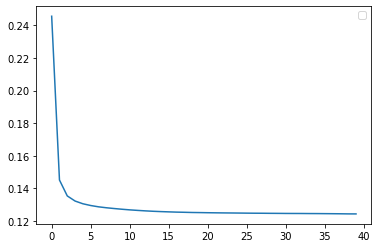

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


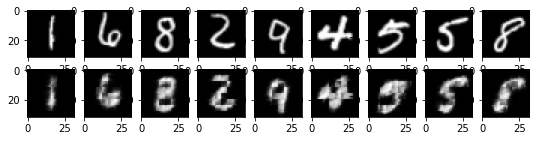

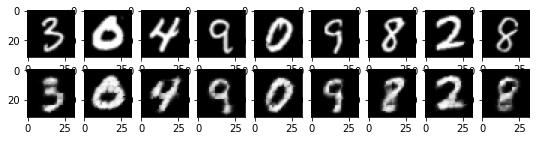

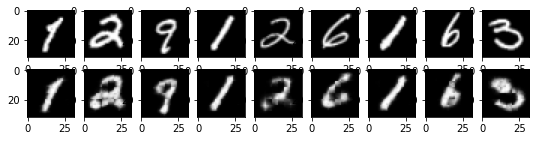

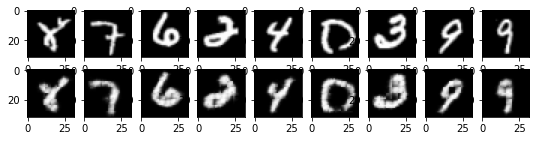

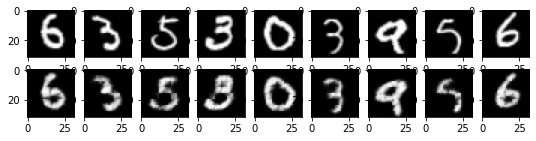

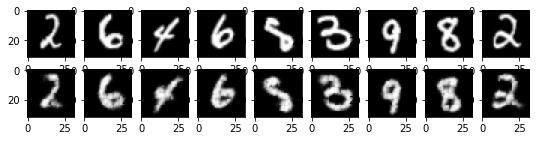

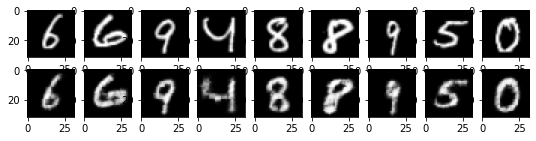

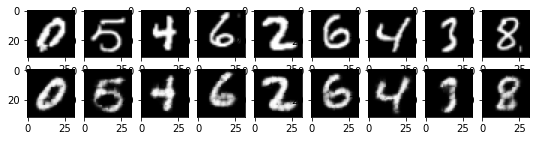

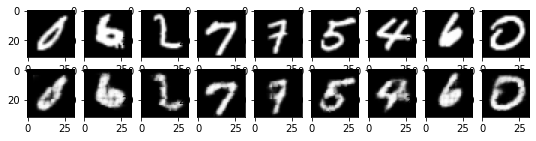

In [ ]:
def train_autoencoder(model, num_epochs=10, learning_rate=1e-3, trainset=trainset_autoencoder, train_loader=train_loader_autoencoder):
    model.train()
    loss_list = []
    torch.manual_seed(42)
    criterion = nn.BCELoss()  # binary cross entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    outputs = []
    for epoch in range(num_epochs):
        loss_counter = 0.0
        counter = 0
        for i, data in tqdm(enumerate(train_loader), total=int(len(trainset)/train_loader.batch_size)):
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_counter += loss.item()
            counter += 1
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss_counter / counter))
        loss_list.append(loss_counter / counter)
        outputs.append((i, img, recon),)
    plt.plot(loss_list)
    plt.legend('loss', 'epochs')
    plt.show()
    torch.save(model.encoder.state_dict(), 'encoder_model.pth')
    torch.save(model.decoder.state_dict(), 'decoder_model.pth')

    return outputs

model = ConvAutoencoder()
max_epochs = 40
outputs = train_autoencoder(model, num_epochs=max_epochs)

for k in range(0, max_epochs):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0], cmap='gray')

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0], cmap='gray')

plt.show()


# MLP Architecture

In [32]:
class Mlp(nn.Module):
    def __init__(self, input_dim=latent_dim):
        super(Mlp, self).__init__()
        self.linear1 = nn.Linear(input_dim, input_dim * 2)
        self.linear2 = nn.Linear(input_dim * 2, input_dim)
        self.linear3 = nn.Linear(input_dim, input_dim)
        self.linear4 = nn.Linear(input_dim, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        return x        


# MLP + Encoder Architecture

In [20]:
class MLPEncoder(nn.Module):

    def __init__(self):
        super(MLPEncoder, self).__init__()
        self.encoder = Encoder()
        self.mlp = Mlp()

    def forward(self, x):
        x = self.encoder(x)
        x = self.mlp(x)
        return x

# Train MLP + Encoder

In [ ]:
def train_classifier(model, train_loader, trainset, encoder, criterion, optimizer):
    model.train()
    loss_counter = 0.0
    acc_counter = 0.0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=int(len(trainset)/train_loader.batch_size)):
        img, labels = data
        if encoder:
            img = encoder(img)
        predict = model(img)
        loss = criterion(predict, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_counter += loss.item()
        acc_counter += calculate_accuracy(labels, predict).item()
        counter += 1
    return loss_counter, acc_counter, counter


def eval_classifier(model, test_loader, testset, encoder, criterion):
    model.eval()
    loss_counter = 0.0
    acc_counter = 0.0
    counter = 0
    for i, data in tqdm(enumerate(test_loader), total=int(len(testset) / test_loader.batch_size)):
        img, labels = data
        if encoder:
            img = encoder(img)
        predict = model(img)
        loss = criterion(predict, labels)
        loss_counter += loss.item()
        acc_counter += calculate_accuracy(labels, predict).item()
        counter += 1
    return loss_counter, acc_counter, counter


def classifier(model, num_epochs=10, learning_rate=1e-3, trainset=trainset_mlp, train_loader=train_loader_mlp, model_name='Mlp'):
    loss_list = []
    acc_list = []
    loss_list_test = []
    acc_list_test = []
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()  # cross entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    encoder = None
    if model_name == 'Mlp':
        encoder = Encoder()
        encoder.load_state_dict(copy.deepcopy(torch.load("encoder_model.pth", device)))
    for epoch in range(num_epochs):
        loss_counter, acc_counter, counter = train_classifier(model, train_loader, trainset, encoder, criterion, optimizer)
        loss_counter_test, acc_counter_test, counter_test = eval_classifier(model, testloader, testset, encoder, criterion)
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss_counter / counter))
        print('Epoch:{}, acc:{:.4f}'.format(epoch+1, acc_counter / counter))
        print('Epoch:{}, Loss test:{:.4f}'.format(epoch+1, loss_counter_test / counter_test))
        print('Epoch:{}, acc test:{:.4f}'.format(epoch+1, acc_counter_test / counter_test))
        loss_list.append(loss_counter / counter)
        acc_list.append(100 * acc_counter / counter)
        loss_list_test.append(loss_counter_test / counter_test)
        acc_list_test.append(100 * acc_counter_test / counter_test)
    plt.plot(loss_list)
    plt.plot(loss_list_test)
    plt.title('loss')
    plt.legend(['train', 'test'])
    plt.show()
    plt.plot(acc_list)
    plt.plot(acc_list_test)
    plt.title('accuracy')
    plt.legend(['train', 'test'])
    plt.show()


model = Mlp()
max_epochs = 20
outputs = classifier(model, num_epochs=max_epochs, learning_rate=0.02, model_name='Mlp')

model = MLPEncoder()
max_epochs = 20
outputs = classifier(model, num_epochs=max_epochs, learning_rate=0.01, model_name='MLPEncoder')


# GAN Architecture

In [83]:
class Generator(nn.Module):
    def __init__(self, input_dim=latent_dim):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(input_dim, input_dim * 2)
        self.linear2 = nn.Linear(input_dim * 2, input_dim * 2)
        self.linear3 = nn.Linear(input_dim * 2, input_dim * 2)
        self.linear4 = nn.Linear(input_dim * 2, input_dim * 2)
        self.linear5 = nn.Linear(input_dim * 2, input_dim)
        self.linear6 = nn.Linear(input_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.relu(self.linear4(x))
        x = self.relu(self.linear5(x))
        x = self.linear6(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(latent_dim, latent_dim * 2)
        self.linear2 = nn.Linear(latent_dim * 2, latent_dim * 2)
        self.linear3 = nn.Linear(latent_dim * 2, latent_dim * 2)
        self.linear4 = nn.Linear(latent_dim * 2, latent_dim * 2)
        self.linear5 = nn.Linear(latent_dim * 2, latent_dim)
        self.linear6 = nn.Linear(latent_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.relu(self.linear4(x))
        x = self.relu(self.linear5(x))
        x = self.sigmoid(self.linear6(x))
        return x

# Train GAN

938it [00:35, 26.64it/s]                         


Epoch:1, Loss discriminator:614.0812
Epoch:1, Loss generator:1770.5203


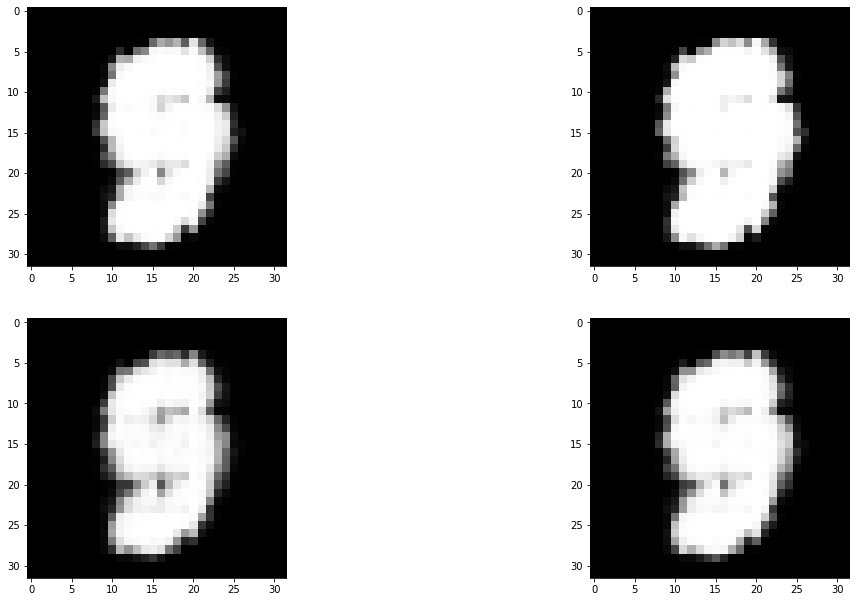

938it [00:36, 25.73it/s]                         


Epoch:2, Loss discriminator:879.6755
Epoch:2, Loss generator:1244.7815


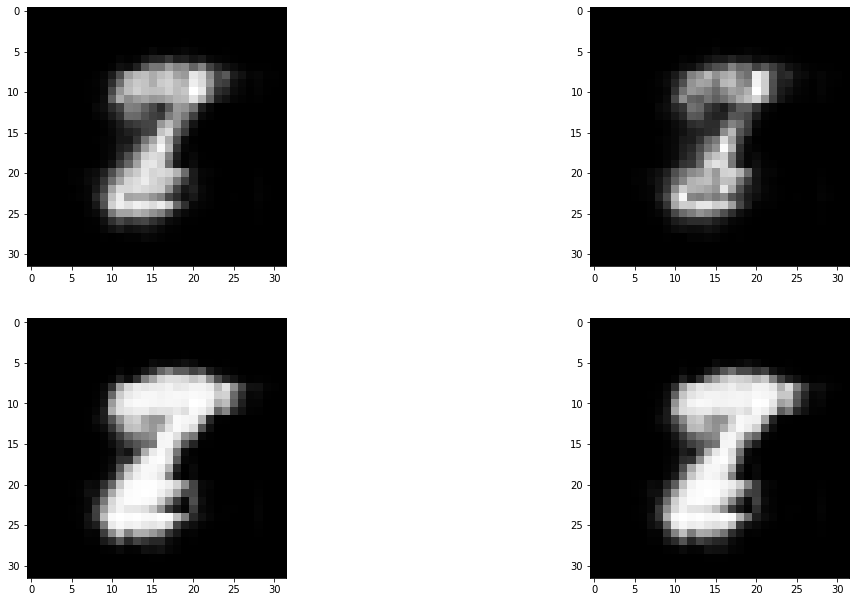

938it [00:34, 27.19it/s]                         


Epoch:3, Loss discriminator:493.8051
Epoch:3, Loss generator:1814.8607


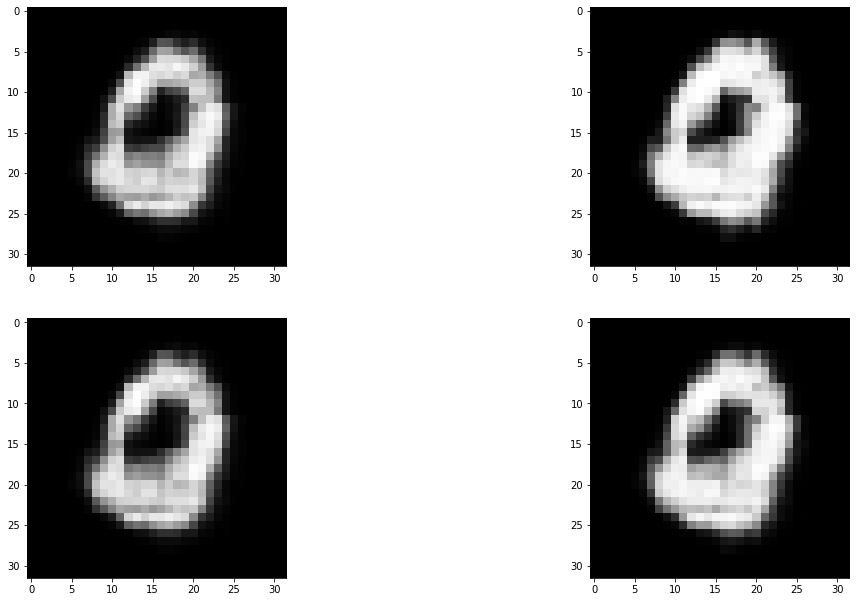

938it [00:34, 26.82it/s]                         


Epoch:4, Loss discriminator:407.8848
Epoch:4, Loss generator:1947.7628


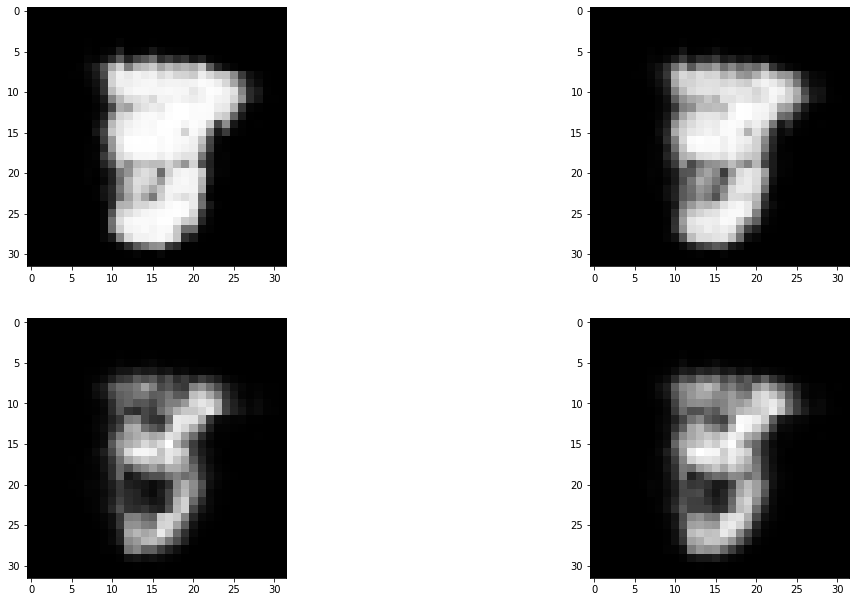

938it [00:34, 26.88it/s]                         


Epoch:5, Loss discriminator:316.9832
Epoch:5, Loss generator:2313.2185


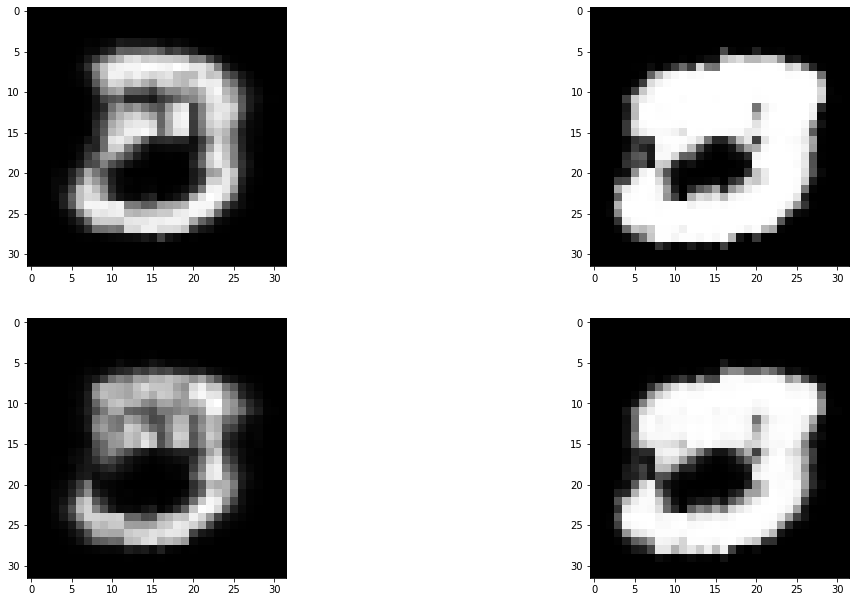

938it [00:34, 26.87it/s]                         


Epoch:6, Loss discriminator:738.3264
Epoch:6, Loss generator:1654.1111


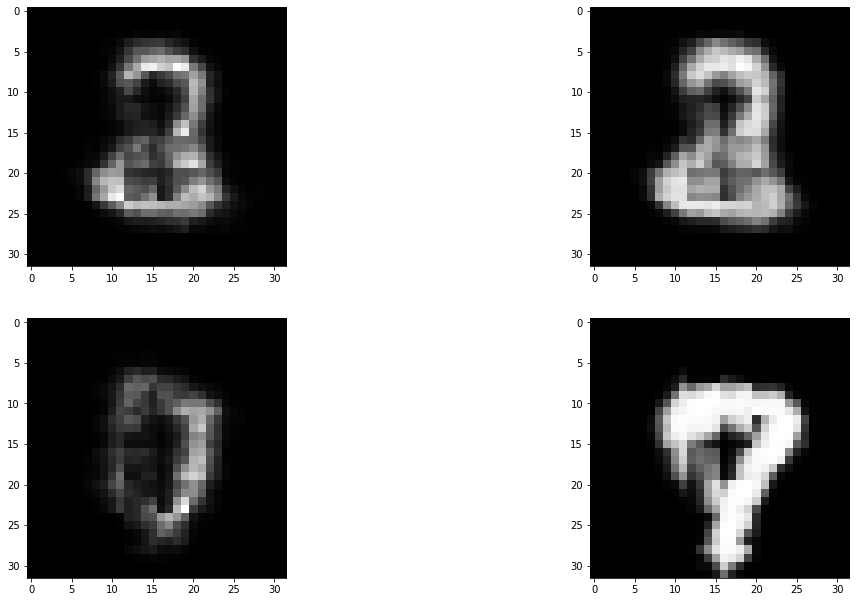

938it [00:35, 26.75it/s]                         


Epoch:7, Loss discriminator:678.2398
Epoch:7, Loss generator:1728.3085


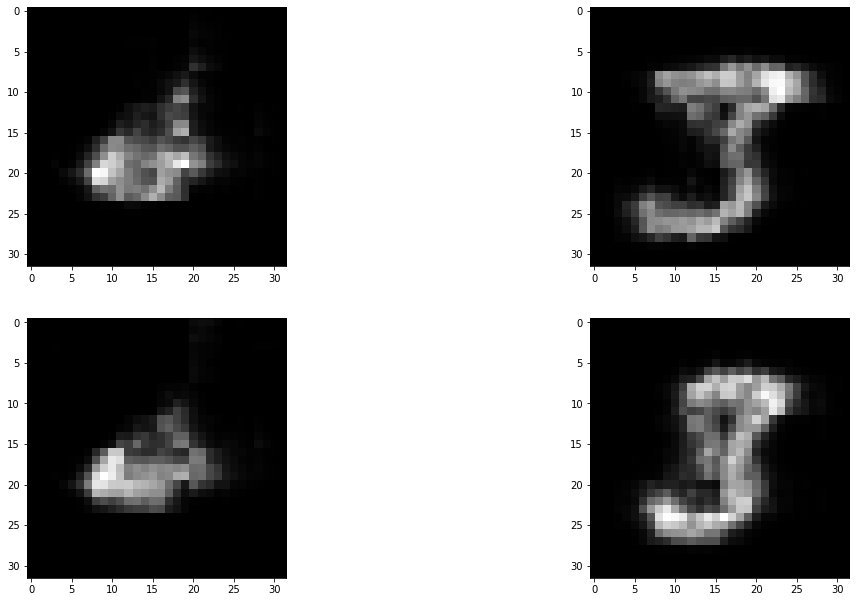

938it [00:34, 26.81it/s]                         


Epoch:8, Loss discriminator:952.1403
Epoch:8, Loss generator:1093.4618


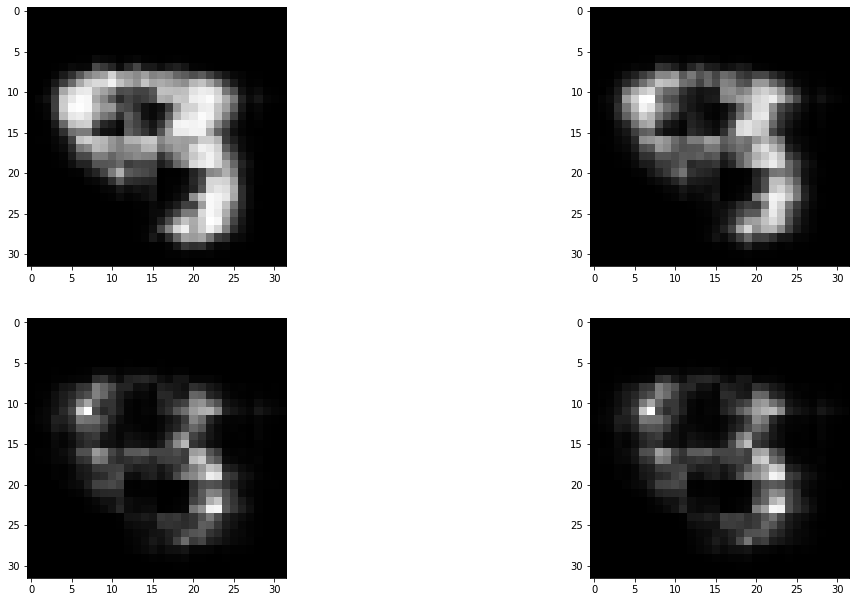

938it [00:35, 26.75it/s]                         


Epoch:9, Loss discriminator:1014.3168
Epoch:9, Loss generator:1047.4839


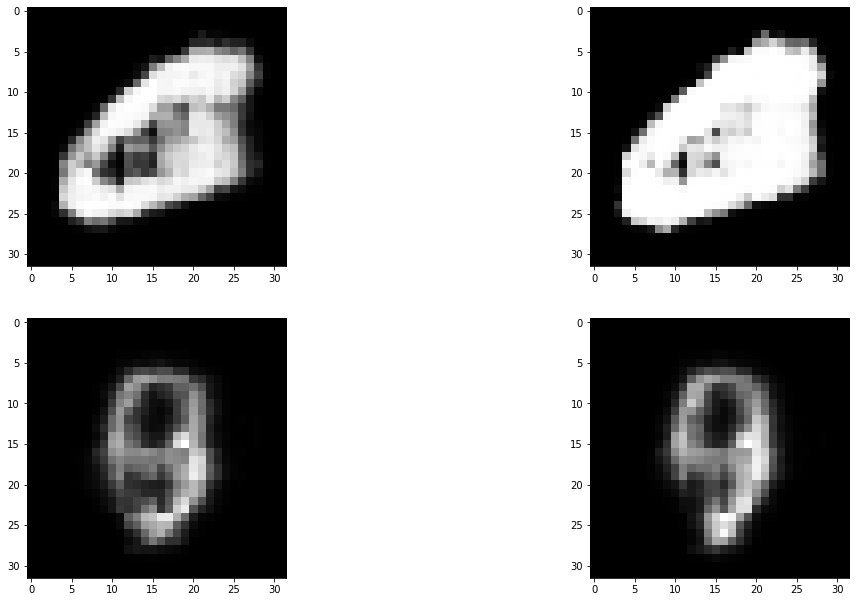

938it [00:35, 26.57it/s]                         


Epoch:10, Loss discriminator:826.7919
Epoch:10, Loss generator:1264.3875


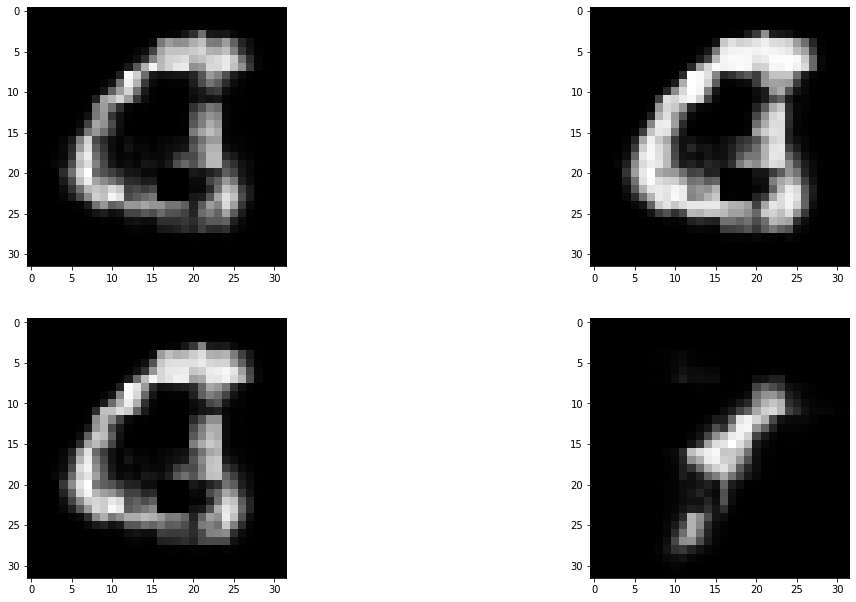

938it [00:35, 26.69it/s]                         


Epoch:11, Loss discriminator:722.9883
Epoch:11, Loss generator:1587.0701


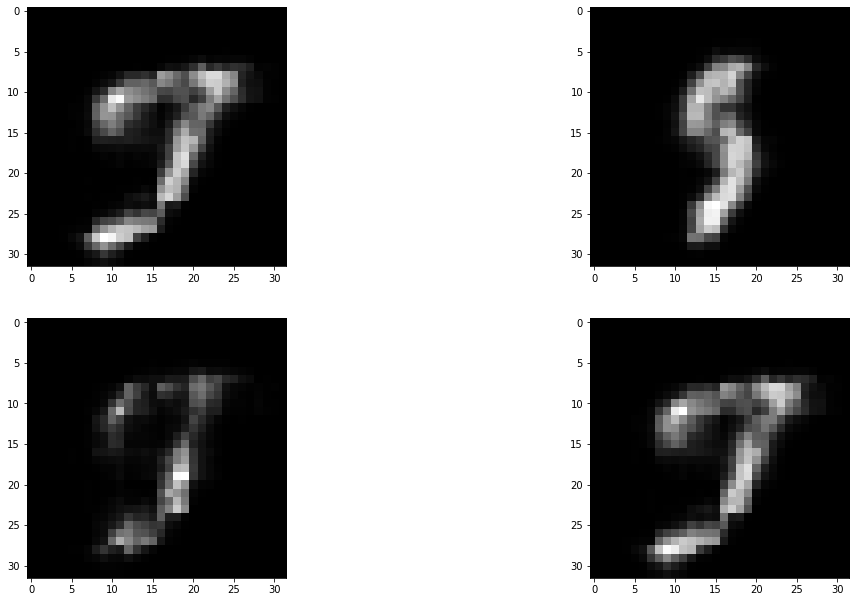

 20%|█▉        | 187/937 [00:06<00:27, 26.83it/s]


KeyboardInterrupt: ignored

In [114]:

def forward_and_backward(model, data, loss_function, targets):
    """
      Perform forward and backward pass in a generic way. Returns loss value.
    """
    outputs = model(data)
    error = loss_function(outputs, targets)
    error.backward()
    return error.item()


def generate_latent(number_of_images=batch_size, latent_dimension=10):
    """ Generate noise for number_of_images images, with a specific noise_dimension """
    return torch.randn(number_of_images, latent_dimension)


def initialize_loss():
    """ Initialize loss function. """
    return nn.BCELoss()


def initialize_optimizers(generator, discriminator, lr_genrator, lr_discriminator):
    """ Initialize optimizers for Generator and Discriminator. """
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_genrator, betas=(0.5, 0.999))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(0.5, 0.999))
    return generator_optimizer, discriminator_optimizer


def train_epoch(generator, discriminator, encoder, loss_function, generator_optimizer, discriminator_optimizer):
    real_label, fake_label = 1.0, 0.0
    loss_dis = 0.0
    loss_gen = 0.0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainset)/trainloader.batch_size)):
        # train discriminator
        discriminator.zero_grad()
        img, _ = data
        real_images = encoder(img)
        label = torch.full((img.shape[0],1), real_label)
        output = discriminator(real_images)
        error_real_images = loss_function(output, label)
        error_real_images.backward()
        D_x = output.mean().item()

        latent = generate_latent(img.shape[0])
        fake = generator(latent)
        label.fill_(fake_label)
        output = discriminator(fake.detach())
        error_fake_images = loss_function(output, label)
        error_fake_images.backward()
        D_G_z1 = output.mean().item()
        errD = error_real_images + error_fake_images
        discriminator_optimizer.step()

        # train generator
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

        loss_dis += errD
        loss_gen += errG

    return loss_dis, loss_gen


def train(generator, discriminator, num_epochs=30, lr_discriminator=1e-3, lr_generator=1e-3, trainset=trainset, train_loader=trainloader):
    loss_discriminator = []
    loss_generator = []
    torch.manual_seed(42)
    encoder = Encoder()
    encoder.load_state_dict(copy.deepcopy(torch.load("encoder_model.pth", device)))
    criterion = nn.BCELoss()
    generator_optimizer, discriminator_optimizer = initialize_optimizers(generator, discriminator, lr_generator, lr_discriminator)
    for epoch in range(num_epochs):
        loss_dis, loss_gen = train_epoch(generator, discriminator, encoder, criterion, generator_optimizer, discriminator_optimizer)
        print('Epoch:{}, Loss discriminator:{:.4f}'.format(epoch+1, loss_dis))
        print('Epoch:{}, Loss generator:{:.4f}'.format(epoch+1, loss_gen))
        loss_discriminator.append(loss_dis)
        loss_generator.append(loss_gen)
        generate_images(generator)
    plt.plot(loss_discriminator)
    plt.title('loss discriminator')
    plt.show()
    plt.plot(loss_generator)
    plt.title('loss generator')
    plt.show()
    torch.save(generator.state_dict(), 'generator.pth')


generator = Generator()
discriminator = Discriminator()
num_epochs = 20
train(generator, discriminator, num_epochs, lr_discriminator=0.0002, lr_generator=0.0002)

# Generate images

In [94]:
# generator = Generator()
# generator.load_state_dict(copy.deepcopy(torch.load("generator.pth", device)))
def generate_images(generator=generator):
    decoder = Decoder()
    decoder.load_state_dict(copy.deepcopy(torch.load("decoder_model.pth", device)))

    latents = generate_latent()
    generate_images = generator(latents)
    outputs = decoder(generate_images)

    plt.figure(figsize=(4, 4))
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    recon = outputs.detach().numpy()
    for i, item in enumerate(recon):
        if i >= 16: break
        plt.subplot(4, 4, 0+i+1)
        plt.imshow(item[0], cmap='gray')

    plt.show()


# generate_images()